# Churned Customers and How to find Them
## 1. Abstract
Due to non-contractual nature between users and our application, it's vital to seperate customers who are still active on MyVIB to who seemingly have left pernamently (*churned customers*). Fortunately, *churn defition* and *churn prediction* is an active and evolving field of research. Most papers that explored similar problems (fremium game, e-commerce, retail store...) used ***inactive duration*** as the defining statistics to classify whether or not a given customer has churned. Using this same technique, I explored the datasets and found that ***20 days*** is the most approriate ***inactive duration***, which should only give us **5% false positive rate** over any sufficient period of time.
## 2. Paper with Code
### 1. The Big Picture

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

paths = Path.cwd() / "data"
paths = list(paths.glob("*.*"))

# for production only to produce pretty notebook
import warnings
warnings.filterwarnings('ignore')

There are 6 dataset, but we only need to explore datasets 2.Data_MyVIB_Transaction and 3.Data_MyVIB_Activity as they are directly tied and exclusive to MyVIB application. Other datasets are useful, but it may contain activities from other platform (direct banking, web, mobile...) which I cannot easily distinguish.

In [3]:
# Import and preprocess dataset 2
df_trans = pd.read_csv(paths[2], dtype={"TRANS_LV1":"category","TRANS_LV2":"category","DAY_OF_WEEK":"category"}, parse_dates=[2])
df_trans["TRANS_ID"] = df_trans.index
df_trans.index = df_trans["TRANS_DATE"]
df_trans

,TRANS_LV1,TRANS_LV2,TRANS_DATE,DAY_OF_WEEK,TRANS_HOUR,TRANS_NO,TRANS_AMOUNT,CUSTOMER_NUMBER,TRANS_ID
TRANS_DATE,,,,,,,,,
2019-01-03,Transfer,Outside_VIB,2019-01-03,Thu,17,2,189771864.0,701619,0
2019-07-01,Transfer,Outside_VIB,2019-07-01,Mon,13,2,30224900.0,701619,1
2019-01-02,Transfer,Outside_VIB,2019-01-02,Wed,15,1,100000.0,701619,2
2019-01-03,Payment,Credit_card_repayment,2019-01-03,Thu,14,1,85000000.0,262123,3
2019-01-28,Payment,Credit_card_repayment,2019-01-28,Mon,22,1,83000000.0,262123,4
...,...,...,...,...,...,...,...,...,...
2019-12-31,Transfer,Outside_VIB,2019-12-31,Tue,16,1,8400000.0,9852,1418025
2019-12-31,Payment,Credit_card_repayment,2019-12-31,Tue,11,2,499000.0,807647,1418026
2019-12-31,Payment,Credit_card_repayment,2019-12-31,Tue,16,1,20957808.0,791916,1418027


In [4]:
# Import and preprocess dataset 3
df_actv = pd.read_csv(paths[3], dtype={"DAY_OF_WEEK":"category","ACTIVITY_NAME":"category"}, parse_dates=[0])
df_actv["ACTIVITY_ID"] = df_actv.index
df_actv.index = df_actv["ACTIVITY_DATE"]
df_actv

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME,ACTIVITY_ID
ACTIVITY_DATE,,,,,,,
2019-01-22,2019-01-22,Tue,20,2,630178,MB_INTEREST_RATE_VIEW,0
2019-01-10,2019-01-10,Thu,18,16,630178,MB_INTEREST_RATE_VIEW,1
2019-01-26,2019-01-26,Sat,17,15,630178,MB_INTEREST_RATE_VIEW,2
2019-01-02,2019-01-02,Wed,9,27,630178,MB_INTEREST_RATE_VIEW,3
2019-01-19,2019-01-19,Sat,8,3,630178,MB_INTEREST_RATE_VIEW,4
...,...,...,...,...,...,...,...
2019-11-01,2019-11-01,Fri,11,1,327258,TRANSFER_VIB_ACCOUNT_BULK,16132670
2019-12-02,2019-12-02,Mon,15,1,327258,TRANSFER_VIB_ACCOUNT_BULK,16132671
2019-11-19,2019-11-19,Tue,17,1,882344,TRANSFER_VIB_ACCOUNT_BULK,16132672


Let's count all transactions and activities and visualize the results

<AxesSubplot:title={'center':'Number of transactions recorded in MyVIB database'}, xlabel='Date', ylabel='Number of Transactions'>

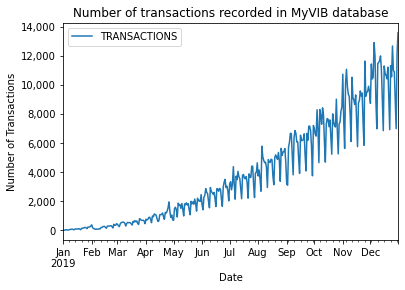

In [5]:
trans_count = df_trans[["CUSTOMER_NUMBER", "TRANS_ID"]].groupby(["TRANS_DATE", "CUSTOMER_NUMBER"]).count()
trans_count = trans_count.rename(columns={"TRANS_ID":"TRANSACTIONS"})
trans_count_all = trans_count.sum(level=0)
trans_count_all = trans_count_all.reindex(pd.date_range(start="2019-01-01", end="2019-12-31"), fill_value=0)
trans_count_all_ax = trans_count_all.plot(title="Number of transactions recorded in MyVIB database",ylabel="Number of Transactions", xlabel="Date")
trans_count_all_ax.set_yticklabels([f'{x:,.0f}' for x in trans_count_all_ax.get_yticks()])
trans_count_all_ax

This is a nice example of time series data, with clear trend and seasonality. Even though time series decomposition isn't relevant to our problem right now (we only need to know **if user is active**, we don't need to know **how active**), I guess Transactions (and Activities) data is weekly-cyclical.

<AxesSubplot:title={'center':'Number of activities recorded in MyVIB database'}, xlabel='Date', ylabel='Number of Activities'>

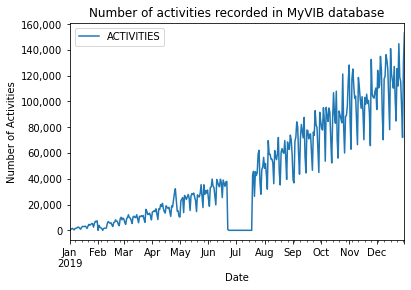

In [6]:
actv_count = df_actv[["CUSTOMER_NUMBER", "ACTIVITY_ID"]].groupby(["ACTIVITY_DATE", "CUSTOMER_NUMBER"]).count()
actv_count = actv_count.rename(columns={"ACTIVITY_ID":"ACTIVITIES"})
actv_count_all = actv_count.sum(level=0)
actv_count_all = actv_count_all.reindex(pd.date_range(start="2019-01-01", end="2019-12-31"), fill_value=0)
actv_count_all_ax = actv_count_all.plot(title="Number of activities recorded in MyVIB database", ylabel="Number of Activities", xlabel="Date")
actv_count_all_ax.set_yticklabels([f'{x:,.0f}' for x in actv_count_all_ax.get_yticks()])
actv_count_all_ax

The Activities data exhibits the same characteristics as Transactions data, but at much higher rate, and there is an abnormal absence of records around July. Fortunately, we can still infer **if user is active** from Transaction data (with some loss). Unfortunately, this will be a big problem for our prediction task later on.

### 2. The Work
In academic language, our data is *right-censored*. It means we don't have any idea what will happen after the observation windows (*31/12/2019*). As there is no definite **quit event** (customers who had left for a long time can still come back later), we can't never be certain if a customer is churned unless we set observation windows to $t\rightarrow\infty$, which in turn makes the whole study irrelevant.  
Hence, I propose the *negative approach* to determine the approriate cutoff. Given an arbitrary ***inactive duration*** assumption (say, 7 days), we can't know if "customer is churned" is true forever (this event is only certain at $t\rightarrow\infty$), but we know we are wrong right away as soon as any "churned" customer returns anytime in the observation windows. In other words, we can calculate the *false positive* rate of our assumption.  
To determine how wrong we will be with any ***inactive duration*** assumptions, we will split durations into 2 sets: censored duration - inactive duration from last activity to the end of observation, and uncensored durations - all inactive durations observed in the period except the last one. We will use the uncensored durations to determine and test our assumptions, and use the censored part to classify whether or not a given customer is churned. The reason for this split is because all censored duration is *opened-ended*, that is, it is not ended, unlike uncensored durations which all have definite end (return of the customer).

In [7]:
# join both into a single table so that we still retain information around July
df = pd.concat([trans_count, actv_count], join="outer", axis=1)
df["IS_ACTIVE"] = df["TRANSACTIONS"].notna() | df["ACTIVITIES"].notna()
# calculate the distance between each active day
df_inactive = df["IS_ACTIVE"].index.to_frame().groupby(level=1).diff()
df_inactive = df_inactive[0]
# drop invalid data at the begining as there are no previous days to calculate the difference
df_inactive_duration = df_inactive.dropna()
# turn distance into duration since distance of 1 means no inactive day in between (both yesterday and today are active), only distance of 2 or above has at least 1 inactive day in between
df_inactive_duration = df_inactive_duration.astype("timedelta64[D]") - 1
# again, we want duration, not distance, so only select duration larger than 0
inactive_duration = df_inactive_duration[df_inactive_duration > 0]
inactive_duration = inactive_duration.value_counts().sort_index()

<AxesSubplot:title={'center':'Number of inactive durations of all users in the sample'}, xlabel='Inactive Duration', ylabel='Number of Durations'>

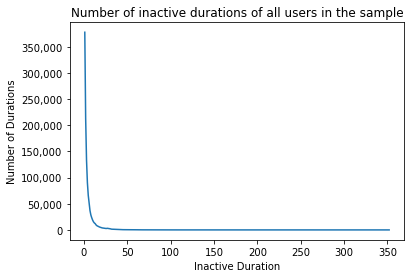

In [8]:
inactv_dur_ax = inactive_duration.plot(title="Number of inactive durations of all users in the sample", ylabel="Number of Durations", xlabel="Inactive Duration")
inactv_dur_ax.set_yticklabels([f'{x:,.0f}' for x in inactv_dur_ax.get_yticks()])
inactv_dur_ax

<AxesSubplot:title={'center':'Cumulative Percentage Sum of Inactive Durations'}, xlabel='Inactive Duration', ylabel='Cumulative Sum'>

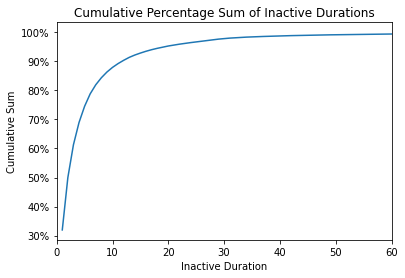

In [9]:
# Calculate the cumulative sum, turn them into percentage, then make a nice graph out of it
cum_days = inactive_duration / inactive_duration.sum()
cumsum_days = cum_days.cumsum()
cumsum_ax = cumsum_days.plot(xlim=(0,60), title="Cumulative Percentage Sum of Inactive Durations", ylabel="Cumulative Sum", xlabel="Inactive Duration") 
# I cheat a little bit since plotting all x-value makes the graph really ugly and hard to discern any pattern, as you can see from previous graph
cumsum_ax.set_yticklabels([f'{x:,.0%}' for x in cumsum_ax.get_yticks()])
cumsum_ax

In [10]:
# 5% false positive rate
possible_cutoff_duration = cumsum_days[cumsum_days >= 0.95]
possible_cutoff_duration

20.0     0.952666
21.0     0.955932
22.0     0.958962
23.0     0.961731
24.0     0.964325
           ...   
332.0    0.999997
336.0    0.999997
337.0    0.999998
345.0    0.999999
352.0    1.000000
Name: 0, Length: 292, dtype: float64

In [11]:
cutoff_duration = possible_cutoff_duration.index.min()
cutoff_duration

20.0

So cut off at 20 days is a good rate. We expect to see only 5% false positive (customers that exceeded the inactive duration yet returned way later). Notice that this is on incidence basis, so a customer who logs in once a month will trip the the alarm multiple times.    
#### Apply the cutoff duration on the censored set to determine if user is churned:

In [12]:
# get the latest active date of each user
df_latest_active = df["IS_ACTIVE"].index.to_frame().groupby(level=1).max()[0]
df_latest_active

0        2019-12-29
3        2019-12-20
9        2019-12-28
13       2019-09-07
15       2019-12-31
            ...    
999966   2019-12-12
999969   2019-12-31
999972   2019-12-30
999982   2019-12-26
999996   2019-12-31
Name: 0, Length: 78112, dtype: datetime64[ns]

In [13]:
latest_inactive_duration = pd.to_datetime("2019-12-31") - df_latest_active
latest_inactive_duration

0          2 days
3         11 days
9          3 days
13       115 days
15         0 days
           ...   
999966    19 days
999969     0 days
999972     1 days
999982     5 days
999996     0 days
Name: 0, Length: 78112, dtype: timedelta64[ns]

In [14]:
latest_inactive_duration = latest_inactive_duration.astype("timedelta64[D]")
left_customers = latest_inactive_duration[latest_inactive_duration >= cutoff_duration]
left_customers

13        115.0
143        32.0
145        21.0
227        27.0
264       122.0
          ...  
999892    211.0
999894    147.0
999932     67.0
999953     96.0
999965     20.0
Name: 0, Length: 19814, dtype: float64

<AxesSubplot:xlabel='Customer ID', ylabel='Days Since Last Activity'>

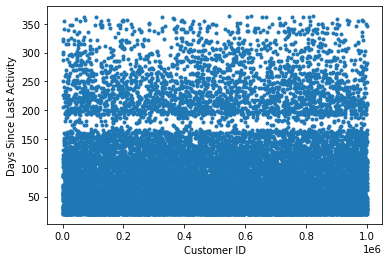

In [15]:
left_customers.plot(style = ".", xlabel="Customer ID", ylabel="Days Since Last Activity")
# the Missing July shows up in our graph

In [16]:
# calculate the attrition rate over a year
left_customers.count() / latest_inactive_duration.count()

0.2536614092585006

### 3. Conclusion
With *negative approach* and 5% tolerance for false positive, I found ***20 days of inactivity*** to be the approriate definition for ***customers who left MyVIB (churned)***. From that definition, we calculated the attrition rate of ***~25.37%/year***, or ***expected lifetime of 3.94 years for each customer***. However, since we are missing a chunk of data in July, we undercounted the frequency of inactive durations around 180 days. It's a very small amount, but I suspect if somehow we could recover that missing data, we could see our cutoff pushed up a little bit to *21 days*, thus lower the attrition rate and increase the customers' expected lifetime accordingly.

## 3. References
Lee, E., Jang, Y., Yoon, D., Jeon, J., Yang, S. I., Lee, S. K., ... & Kim, K. J. (2018). Game data mining competition on churn prediction and survival analysis using commercial game log data. arXiv preprint arXiv:1802.02301.  

Kristensen, J. T., & Burelli, P. (2019, August). Combining sequential and aggregated data for churn prediction in casual freemium games. In 2019 IEEE Conference on Games (CoG) (pp. 1-8). IEEE.  

Hadiji, F., Sifa, R., Drachen, A., Thurau, C., Kersting, K., & Bauckhage, C. (2014, August). Predicting player churn in the wild. In 2014 IEEE Conference on Computational Intelligence and Games (pp. 1-8). Ieee.  

Norbert Schumacher, N. S. (2007). Measuring Customer Lifetime (MLM-41383-48 07/07). Philadelphia University in Jordan. https://www.philadelphia.edu.jo/academics/mararchive/uploads/Measuring%20Customer%20Lifetime.pdf
